In [1]:
%pylab inline
import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
from jax.scipy.ndimage import map_coordinates
import h5py
'unset XLA_FLAGS'

from jax.config import config
config.update("jax_enable_x64", True)


import cmasher as cmr

Populating the interactive namespace from numpy and matplotlib


In [2]:

lognormal_params = np.loadtxt('/gpfs7kw/linkhome/rech/genmfd01/ulm75uc/sbi_lens/sbi_lens/data/lognormal_shift.csv', skiprows=1, delimiter=',').reshape([8,8,3])



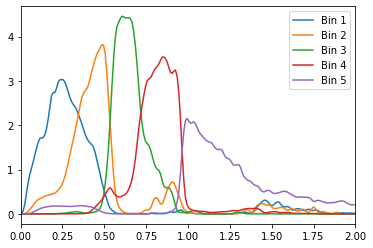

In [3]:
# Reading the DC2 tomographic bins into redshift distribution objects
with h5py.File("shear_photoz_stack.hdf5") as f:
    group = f["n_of_z"]
    # Read the z grid
    source = group["source"]
    z_shear = source['z'][::]
    # Read the true n(z)
    nz_shear = [jc.redshift.kde_nz(z_shear,  
                                   source[f"bin_{i}"][:], 
                                   bw=0.01, zmax=2.5) for i in range(5)] 
for i in range(5):
  plot(z_shear, nz_shear[i](z_shear), color='C%d'%i, label="Bin %d"%(i+1))
legend()
xlim(0,2);

In [4]:
# Here we add the code that interpolates the shift parameters as a function of cosmology
@jax.jit
def shift_fn(omega_m, sigma_8):
  omega_m = jnp.atleast_1d(omega_m)
  sigma_8 = jnp.atleast_1d(sigma_8) 
  return map_coordinates(lognormal_params[:,:,2], jnp.stack([(omega_m - 0.2) / 0.2*8 - 0.5,
                                                             (sigma_8 - 0.6) / 0.4*8 - 0.5], 
                                                            axis=0).reshape([2,-1]) , order=1, mode='nearest').squeeze()

In [119]:
def make_power_map(pk_fn, N, map_size, zero_freq_val=0.0, model_type=None ):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=map_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    if model_type=='no_correlation':
        power_map = ps_map * (N / map_size)**2
    elif model_type=='no_norm':
        power_map = ps_map 
    else:
        power_map = ps_map * (N / map_size)
    return power_map

def make_lognormal_power_map(power_map, shift, zero_freq_val=0.0):
    power_spectrum_for_lognorm = jnp.fft.ifft2(power_map).real
    power_spectrum_for_lognorm = jnp.log(1 +
                                         power_spectrum_for_lognorm / shift**2)
    power_spectrum_for_lognorm = jnp.abs(
        jnp.fft.fft2(power_spectrum_for_lognorm))
    power_spectrum_for_lognorm = power_spectrum_for_lognorm.at[0, 0].set(0.)
    return  power_spectrum_for_lognorm


In [114]:
def lat_z(N=128):   
    z=numpyro.sample('z', dist.MultivariateNormal(loc=jnp.zeros((N,N)), precision_matrix=jnp.eye(N)))
    return z

In [132]:
N=128            
map_size=5   
pix_area = (map_size * 60 / N)**2 # arcmin2 
map_size = map_size / 180 * jnp.pi    # radians
omega_c = 0.3
sigma_8 =0.8
cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
ell_tab = 2 * jnp.pi * abs(jnp.fft.fftfreq(N, d=map_size / (N)))
tracer = jc.probes.WeakLensing([nz_shear[-1]])
shift = shift_fn(cosmo.Omega_m, sigma_8)
cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]

In [133]:
P_1 = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
power_map_1 = make_power_map(P_1, N, map_size, model_type='no_correlation') 
power_map_1 = make_lognormal_power_map(power_map_1, shift)

[0.         0.03387693 0.01565984 0.00918549 0.00625997 0.00465924
 0.00368198 0.00303103 0.00256986 0.00222675]
[4.07660245e-04 1.87630886e-04 8.94596759e-05 6.83889438e-05
 4.97314630e-05 4.27995356e-05 3.46811656e-05 3.08988868e-05
 2.61481794e-05 2.36469119e-05]


In [134]:
def make_lognormal_cl(cl,shift):
    print(cl[:10])
    xsi = jnp.fft.ifft(cl).real
    print(xsi[:10])
    xsi_shift = jnp.log(1 + xsi/(shift)**2)
    cl_shifted =  jnp.abs(jnp.fft.fft(xsi_shift))
    cl_shifted=cl_shifted.at[0].set(0.)
    return  cl_shifted

cell_tab_shifted=make_lognormal_cl(cell_tab*(N / map_size)**2,shift)


[0.         0.03387693 0.01565984 0.00918549 0.00625997 0.00465924
 0.00368198 0.00303103 0.00256986 0.00222675]
[0.00173416 0.00137659 0.00111772 0.00097885 0.00086312 0.00077376
 0.00069213 0.00062225 0.00055678 0.00049847]


In [129]:
jnp.sqrt(N)

DeviceArray(11.3137085, dtype=float64)

In [136]:
1/(4.07660245e-04/0.00173416)

4.253934547873316

In [137]:
P_2 = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab_shifted).reshape(k.shape)
power_map_2 = make_power_map(P_2, N, map_size, model_type='no_norm') 

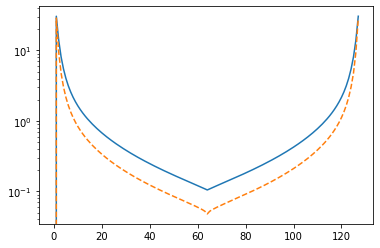

In [138]:
semilogy(power_map_1[0])
semilogy(power_map_2[0], '--')

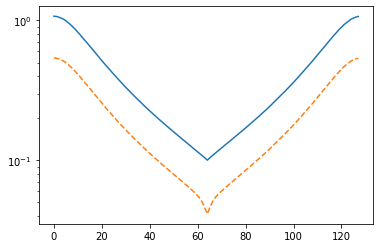

In [139]:
semilogy(power_map_1[14])
semilogy(power_map_2[14], '--')

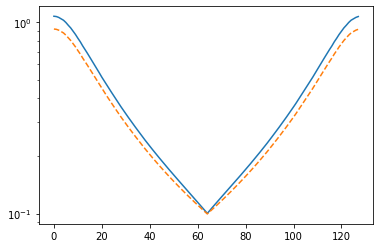

In [82]:
semilogy(power_map_1[14])
semilogy(power_map_2[14], '--')

### Create N mock realization to average over the final angular power spectrum

In [11]:
N_sample = 20

z_list = []
key=jax.random.PRNGKey(14)
for i in range(N_sample):
    print("===================================================")
    print("Sample %d"%(i+1))
    print("===================================================")
    key,subkey=jax.random.split(key)
    sample_map_fiducial = seed(lat_z, subkey)
    z = sample_map_fiducial()
    z_list.append(z)

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Sample 6
Sample 7
Sample 8
Sample 9
Sample 10
Sample 11
Sample 12
Sample 13
Sample 14
Sample 15
Sample 16
Sample 17
Sample 18
Sample 19
Sample 20


### Compare the results with the theory

In [12]:
from lenstools import ConvergenceMap
import astropy.units as u
import itertools
import cmasher as cmr

In [85]:
ell_theory = jnp.linspace(300, 5000, 128)   
cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8)
tracer = jc.probes.WeakLensing([nz_shear[-1]])
cell_theory = jc.angular_cl.angular_cl(cosmo, ell_theory, [tracer])

In [86]:
l_edges_kmap= jnp.linspace(300, 5000, 128)


In [87]:
p_auto_sample_1=[]
p_auto_sample_2=[]
for k in range(N_sample):
    z=z_list[k]
    field_1 = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map_1)).real
    field_1 = shift * (jnp.exp(field_1 - jnp.var(field_1) / 2) - 1)
    field_2 = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map_2)).real
    field_2 = shift * (jnp.exp(field_2 - jnp.var(field_2) / 2) - 1)
    pi_1=ConvergenceMap(field_1, angle=5*u.deg).powerSpectrum(l_edges_kmap)[1]
    pi_2=ConvergenceMap(field_2, angle=5*u.deg).powerSpectrum(l_edges_kmap)[1]
    p_auto_sample_1.append(pi_1)
    p_auto_sample_2.append(pi_2)

In [88]:
Cl_auto_arr_1 =jnp.array(p_auto_sample_1)
Cl_mean_auto_1  = jnp.mean(Cl_auto_arr_1, axis=0)
Cl_lower_auto_1 = jnp.percentile(Cl_auto_arr_1, 2.5, axis=0)
Cl_upper_auto_1 = jnp.percentile(Cl_auto_arr_1, 97.5, axis=0)

In [89]:
Cl_auto_arr_2 = jnp.array(p_auto_sample_2)
Cl_mean_auto_2  = jnp.mean(Cl_auto_arr_2, axis=0)
Cl_lower_auto_2 = jnp.percentile(Cl_auto_arr_2, 2.5, axis=0)
Cl_upper_auto_2 = jnp.percentile(Cl_auto_arr_2, 97.5, axis=0)

In [90]:
ell_sample=ConvergenceMap(field_1, angle=5*u.deg).powerSpectrum(l_edges_kmap)[0]

In [91]:
col = cmr.eclipse([0.,0,0.55,0.85]) 

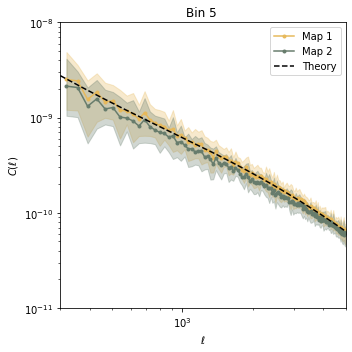

In [92]:
fig, ax = plt.subplots( figsize=(5,5))
ax.set_title('Bin %d '%(5))
ax.set_xlabel('$\ell$')
ax.set_ylabel('$C(\ell)$')
ax.set_xlim(300., 5000.)
ax.set_ylim(1e-11, 1e-8)
ax.loglog(ell_sample, Cl_mean_auto_1, '.-', color=col[3], label='Map 1')
ax.loglog(ell_sample, Cl_mean_auto_2, '.-', color=col[2], label='Map 2')
ax.loglog(ell_theory, cell_theory[0] , '--',  color=col[1], label='Theory')
ax.fill_between(ell_sample, Cl_lower_auto_1, Cl_upper_auto_1, color=col[3], alpha=0.3)
ax.fill_between(ell_sample, Cl_lower_auto_2, Cl_upper_auto_2, color=col[2], alpha=0.3)
ax.legend()
plt.tight_layout()            
plt.show()   

In [21]:
def make_power_map(pk_fn, N, map_size, zero_freq_val=0.0, model_type=None ):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=map_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    if model_type=='no_correlation':
        power_map = ps_map * (N / map_size)**2
    elif model_type=='no_norm':
        power_map = ps_map
    else:
        power_map = ps_
        map * (N / map_size)
    return power_map

def make_lognormal_power_map(power_map, shift, zero_freq_val=0.0):
    power_spectrum_for_lognorm = jnp.fft.ifft2(power_map).real
    power_spectrum_for_lognorm = jnp.log(1 +
                                         power_spectrum_for_lognorm / shift**2)
    power_spectrum_for_lognorm = jnp.abs(
        jnp.fft.fft2(power_spectrum_for_lognorm))
    power_spectrum_for_lognorm = power_spectrum_for_lognorm.at[0, 0].set(0.)
    return  power_spectrum_for_lognorm


def make_lognormal_cl(cl,shift, N, map_size):
    norm_factor=(N / map_size)**2
    xsi = jnp.fft.ifft(cl).real
    xsi_shift = jnp.log(1/norm_factor + xsi/(shift)**2)+jnp.log(norm_factor)
    cl_shifted =  jnp.abs(jnp.fft.fft(xsi_shift))
    cl_shifted=cl_shifted.at[0].set(0.)
    
    return  cl_shifted

cell_tab_shifted=make_lognormal_cl(cell_tab,shift, N, map_size)

In [22]:
cons=(N / map_size)**2

In [23]:
map_norm=make_power_map(P_1, N, map_size, model_type='no_correlation') 
map_no_norm=make_power_map(P_1, N, map_size, model_type='no_norm') 

In [24]:
map_norm-map_no_norm*cons

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

In [41]:
jnp.fft.ifft2(map_norm).real-(jnp.fft.ifft2(map_no_norm).real*cons)

DeviceArray([[-5.42101086e-20, -2.71050543e-20,  1.35525272e-20, ...,
               0.00000000e+00, -1.35525272e-20,  0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  1.35525272e-20, ...,
               0.00000000e+00,  1.35525272e-20,  0.00000000e+00],
             [ 0.00000000e+00,  1.35525272e-20, -1.35525272e-20, ...,
               0.00000000e+00, -1.35525272e-20,  1.35525272e-20],
             ...,
             [ 1.35525272e-20, -1.35525272e-20, -6.77626358e-21, ...,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
               0.00000000e+00, -1.35525272e-20,  1.35525272e-20],
             [ 0.00000000e+00,  0.00000000e+00,  1.35525272e-20, ...,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],            dtype=float64)

In [49]:
cons_map=jnp.full((128,128),cons)

In [39]:
map_norm_ff=jnp.fft.ifft2(map_norm).real
map_no_norm_ff=jnp.fft.ifft2(map_no_norm).real

In [40]:
jnp.log(1/cons+
         map_no_norm_ff/ shift**2)+jnp.log(cons)-jnp.log(1+
         map_norm_ff/ shift**2)

DeviceArray([[-8.32667268e-16,  3.05311332e-16, -7.35522754e-16, ...,
              -4.51028104e-16, -7.35522754e-16,  3.05311332e-16],
             [ 3.05311332e-16,  7.07767178e-16, -4.16333634e-16, ...,
              -9.43689571e-16, -4.16333634e-16,  7.07767178e-16],
             [-7.35522754e-16, -4.16333634e-16,  3.74700271e-16, ...,
               1.38777878e-17,  3.74700271e-16, -4.16333634e-16],
             ...,
             [-4.51028104e-16, -9.43689571e-16,  1.38777878e-17, ...,
               4.30211422e-16,  1.38777878e-17, -9.43689571e-16],
             [-7.35522754e-16, -4.16333634e-16,  3.74700271e-16, ...,
               1.38777878e-17,  3.74700271e-16, -4.16333634e-16],
             [ 3.05311332e-16,  7.07767178e-16, -4.16333634e-16, ...,
              -9.43689571e-16, -4.16333634e-16,  7.07767178e-16]],            dtype=float64)

In [28]:
def make_lognormal_power_map_2(power_map, shift, zero_freq_val=0.0):
    norm_factor=(N / map_size)**2
    power_spectrum_for_lognorm = jnp.fft.ifft2(power_map).real
    power_spectrum_for_lognorm = jnp.log(1/norm_factor +
                                         power_spectrum_for_lognorm / shift**2)+jnp.log(norm_factor)
    power_spectrum_for_lognorm = jnp.abs(
        jnp.fft.fft2(power_spectrum_for_lognorm))
    power_spectrum_for_lognorm = power_spectrum_for_lognorm.at[0, 0].set(0.)
    return  power_spectrum_for_lognorm


def make_lognormal_cl(cl,shift, N, map_size):
    norm_factor=(N / map_size)**2
    xsi = jnp.fft.ifft(cl).real
    xsi_shift = jnp.log(1/norm_factor + xsi/(shift)**2)+jnp.log(norm_factor)
    cl_shifted =  jnp.abs(jnp.fft.fft(xsi_shift))
    cl_shifted=cl_shifted.at[0].set(0.)
    
    return  cl_shifted

cell_tab_shifted=make_lognormal_cl(cell_tab,shift, N, map_size)

In [29]:
P_1 = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
power_map_1 = make_power_map(P_1, N, map_size, model_type='no_norm') 
power_map_1 = make_lognormal_power_map_2(power_map_1, shift)


In [30]:
P_2 = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab_shifted).reshape(k.shape)
power_map_2 = make_power_map(P_2, N, map_size, model_type='no_norm') 


In [31]:

# theta_max=5
# EXTENT = (-0.5 * theta_max, 0.5 * theta_max, -0.5 * theta_max, 0.5 * theta_max)
# cmap = cmr.eclipse
# fig, ax = plt.subplots(1,3, figsize=(15, 10))

# std_kmap = np.std(power_map_1-power_map_2)
# ax[0].imshow(log(power_map_1), cmap=cmap,  extent=EXTENT)
# ax[0].set_title('power_map_1')
# fig.colorbar(ax[0].imshow(log(power_map_1), cmap=cmap, extent=EXTENT) ,fraction=0.047, pad=0.)
# #########
# ax[1].imshow(log(power_map_2), cmap=cmap,  extent=EXTENT)
# ax[1].set_title('power_map_2')
# fig.colorbar(ax[1].imshow(log(power_map_2), cmap=cmap, extent=EXTENT) ,fraction=0.047, pad=0.)
# #########
# ax[2].imshow(log(power_map_1)-log(power_map_2), cmap=cmap ,extent=EXTENT)
# ax[2].set_title('power_map_1-power_map_2')
# fig.colorbar(ax[2].imshow(log(power_map_1)-log(power_map_2), cmap=cmap, extent=EXTENT) ,fraction=0.047, pad=0.)
    
    
    

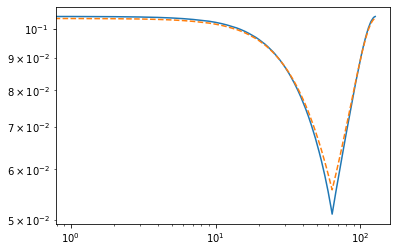

In [32]:
loglog(power_map_1[64])
loglog(power_map_2[64], '--')

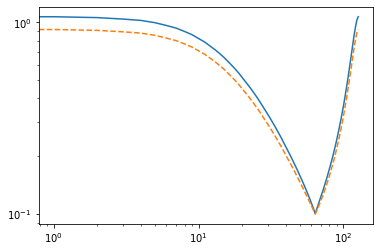

In [33]:
loglog(power_map_1[14])
loglog(power_map_2[14], '--')

In [34]:

def make_lognormal_cl(cl,shift):
    xsi = jnp.fft.ifft(cl).real
    xsi_shift = jnp.log(1 + xsi/(shift)**2)
    cl_shifted =  jnp.abs(jnp.fft.fft(xsi_shift))
    cl_shifted=cl_shifted.at[0].set(0.)
    
    return  cl_shifted

cell_tab_shifted=make_lognormal_cl(cell_tab,shift)

In [35]:
P_1 = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
power_map_1 = make_power_map(P_1, N, map_size, model_type='no_correlation') 
power_map_1 = make_lognormal_power_map(power_map_1, shift)


P_2 = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab_shifted).reshape(k.shape)
power_map_2 = make_power_map(P_2, N, map_size, model_type='no_correlation') 


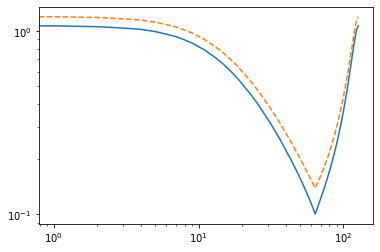

In [36]:
loglog(power_map_1[14])
loglog(power_map_2[14], '--')

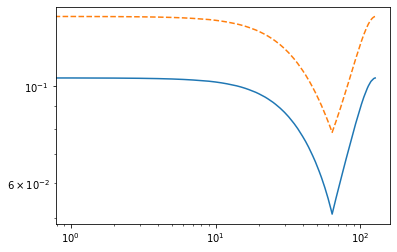

In [37]:
loglog(power_map_1[64])
loglog(power_map_2[64], '--')